<div style="background:#FFFFAA">
<img src="logo.jpg", width=150, ALIGN="left", border=20>


<br>This code was tested with <br>
Python 3.8.5 |Anaconda custom (64-bit)| (default, Sep  4 2020, 02:22:02) (https://anaconda.org/)<br>
<i> Adapted for original code of Balázs Kégl</i> <br>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p>

In this challenge you are going to try to classify whether a picture of a lung is that of a pneumonia patient. 

</div>

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
#model_dir = '../FILES/pretty_good_sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'

from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
# %load_ext autoreload
# %autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import sklearn.model_selection
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.patches

import time
import os
import copy
from pathlib import Path
import shutil
import sys
import pickle

import random
# from PIL import Image, ImageDraw, ImageFont
import PIL
from sklearn.model_selection import train_test_split
# import cv2
import scipy.ndimage.interpolation

from functools import partial

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
</div>

In [4]:
# import os
sample_imgs_dir = 'sample_images'
sample_imgs_names = os.listdir(sample_imgs_dir)

data_dir = Path('../FILES/')
imgs_dir = Path('../FILES/crop')
print(len(os.listdir(imgs_dir)))

14863


First we show you the original data, that is radiology images from healthy and sick individuals. This data was used to create the data that your classification will run on.

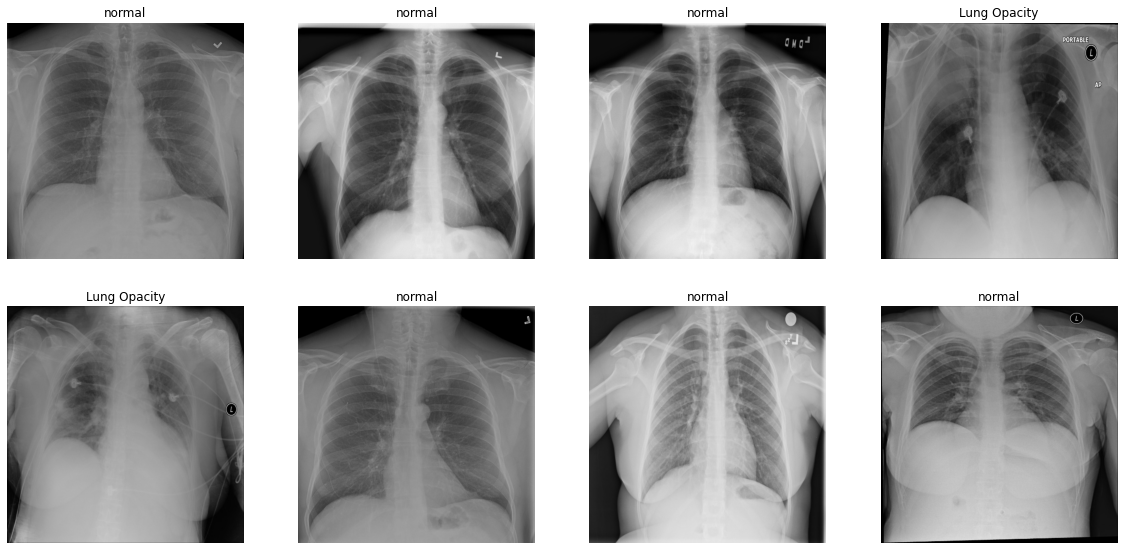

In [5]:
def show_images(images, rows=4, cols=4, figsize=(20, 20),title=None):
    figure = plt.figure(figsize=figsize)
    for idx, img in enumerate(images):
        label = img.split('_')[1].split('.')[0] 
        ax = plt.subplot(rows, cols, idx + 1)
        img = matplotlib.image.imread(os.path.join(sample_imgs_dir, img))
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        if idx > 6:
            break
    if title is not None:
        plt.title(title)
show_images(sample_imgs_names)

We have taken parts of the original image out of the originial images so that the model cannot rely on watermarks and artifacts from special radiology equipment.

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

In [6]:
crop_dir = Path(data_dir)
metadata = pd.read_csv(crop_dir.joinpath('hygieia-train.csv'), index_col=0)
display(metadata.describe())
display(metadata.sample(5))
print(metadata.shape)


,x,y,width,height,Target,boxes
count,4394.000000,4394.000000,4394.000000,4394.000000,10863.000000,10863.000000
mean,385.778789,376.680701,215.949704,312.591944,0.404492,1.237043
std,204.228138,149.385785,58.947321,153.808845,0.490816,0.448264
min,2.000000,2.000000,54.000000,45.000000,0.000000,1.000000
25%,204.000000,257.250000,174.000000,191.000000,0.000000,1.000000
50%,304.000000,379.500000,214.000000,282.000000,0.000000,1.000000
75%,590.000000,488.000000,256.000000,414.000000,1.000000,1.000000
max,817.000000,881.000000,467.000000,942.000000,1.000000,4.000000


,new_path,x,y,width,height,Target,class,boxes
3725,8825.jpg,NaN,NaN,NaN,NaN,0,Normal,1
5663,3146.jpg,131.0,492.0,346.0,416.0,1,Lung Opacity,2
3294,8414.jpg,NaN,NaN,NaN,NaN,0,Normal,1
3101,8229.jpg,NaN,NaN,NaN,NaN,0,Normal,1
7582,12070.jpg,NaN,NaN,NaN,NaN,0,Normal,1


(10863, 8)


In [7]:
#https://github.com/utkuozbulak/pytorch-custom-dataset-examples/blob/master/README.md#incorporating-pandas
    
class ImgDataset(torch.utils.data.Dataset):
    def __init__(self,df,img_dir, transform):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.transform = transform
        # First column contains the image paths
        self.df=df
        self.img_dir=img_dir
        self.image_arr = np.asarray(self.df['new_path'])
        self.label_arr = np.asarray(self.df['Target'])

        self.data_len = len(self.df.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        img_as_img = PIL.Image.open(self.img_dir.joinpath(single_image_name)).convert("RGB")
        img_transformed = self.transform(img_as_img) if self.transform else img_as_img
        
        single_image_label = self.label_arr[index]

        return img_transformed, single_image_label

    def __len__(self):
        return self.data_len

In [8]:
train_df, valid_df = sklearn.model_selection.train_test_split(
    metadata, test_size=0.2, 
    random_state=420, shuffle=True, 
    stratify=metadata['Target'],
)

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_ds=ImgDataset(train_df,imgs_dir, transform)
valid_ds=ImgDataset(valid_df,imgs_dir, transform)

print(len(train_ds))
print(len(valid_ds))

8690
2173


In [10]:
batch_size = 64
dataloaders = {'val':torch.utils.data.DataLoader(valid_ds, batch_size=batch_size,
                                             shuffle=False, 
                                            #  num_workers=4,
                                             )
              ,
              'train':torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                             shuffle=True, 
                                            #  num_workers=4,
                                             )
               }

dataset_sizes = {'val': len(valid_ds),
                 'train':len(train_ds)
                 }
class_names=['Normal','Opacity']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:

inputs, labels = next(iter(dataloaders['train']))
sample_size = 16
sample_index = np.random.randint(0, len(inputs), sample_size)

sample_images = inputs[sample_index]
sample_labels = labels[sample_index]
print(sample_images.shape, sample_labels.shape)


torch.Size([16, 3, 100, 100]) torch.Size([16])


In [12]:
def show_images(images, labels, class_names=class_names, rows=4, cols=4, figsize=(16, 16),title=None):
    """Imshow for Tensor."""

    figure = plt.figure(figsize=figsize)
    for idx, img in enumerate(images):
      ax = plt.subplot(rows, cols, idx + 1)
      plt.imshow(img.numpy().transpose((1, 2, 0)))
      plt.title(class_names[labels[idx]])
      plt.axis('off')

    if title is not None:
        plt.title(title)

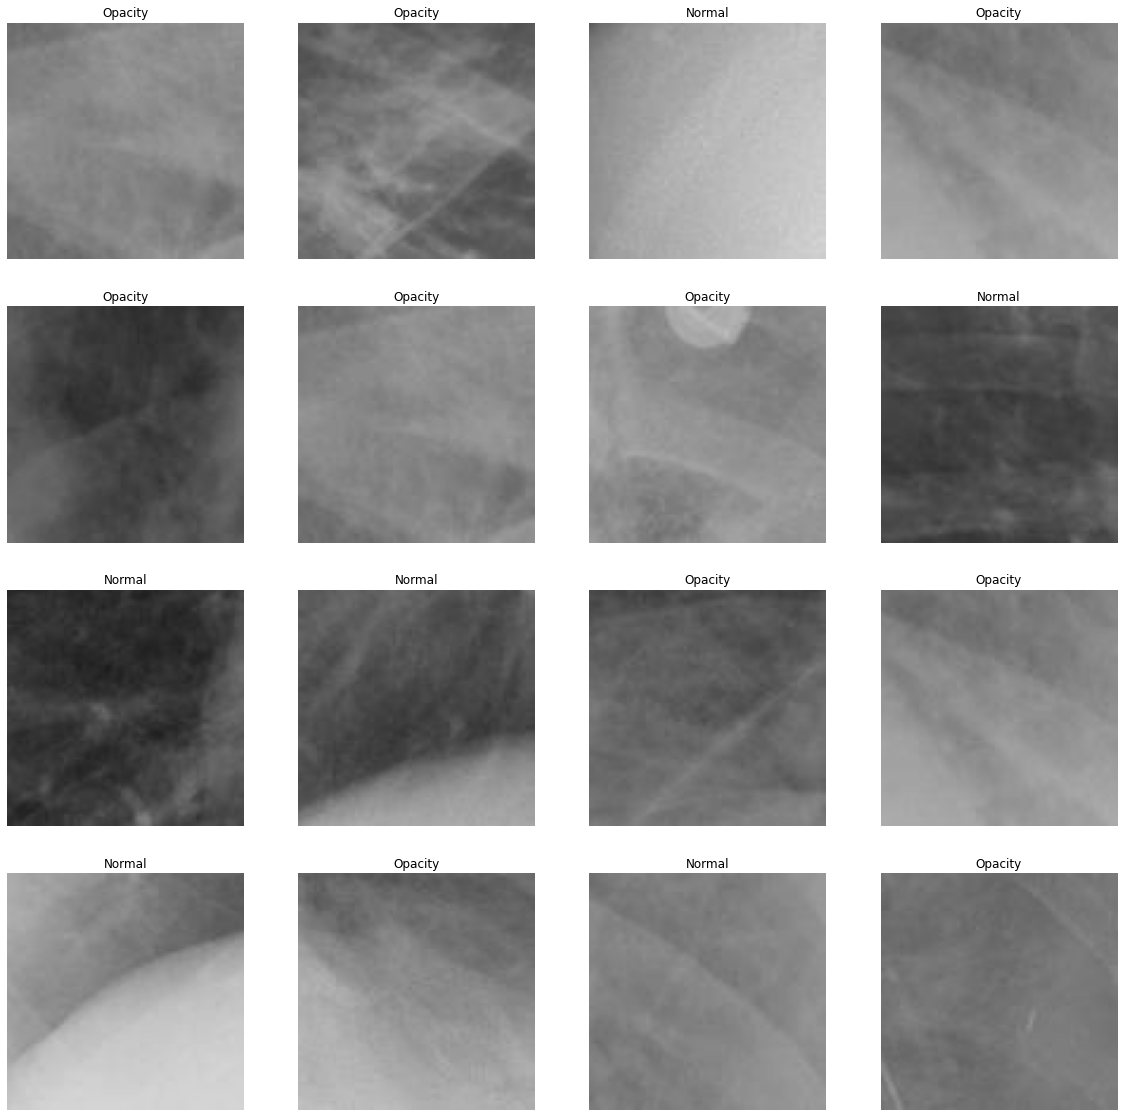

In [13]:
show_images(sample_images, sample_labels, figsize=(20, 20))

<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [13]:
from model import model
#M = model()
#trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
#M = M.load(trained_model_name)

In [14]:
def get_model():
    model = models.mobilenet_v2(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)
    return model.to(device)

In [15]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_history = []
    score_history = []
    train_loss, train_score, valid_loss, valid_score = [], [], [], []

    for epoch in range(num_epochs):
        print('\n','Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # end dataloader loop

            if phase == 'train':
                scheduler.step()
#                 loss_history.append(running_loss)
#                 score_history.append(running_corrects)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_history, score_history = (train_loss, train_score) if phase == 'train' else (valid_loss, valid_score)
            loss_history.append(epoch_loss)
            score_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        # end phase loop

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return dict(   
        model = model,
        train_loss = train_loss,
        train_score = train_score,
        valid_loss = valid_loss,
        valid_score = valid_score,
    )

In [16]:
M = get_model()
# M = model()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(M.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


train_result = train_model(M, criterion, optimizer_conv,
                      exp_lr_scheduler, num_epochs=5)
# M.fit(dataloaders)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/phanav/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100.0%



 Epoch 0/4
----------
train Loss: 0.4993 Acc: 0.7533
val Loss: 0.4511 Acc: 0.7892

 Epoch 1/4
----------


KeyboardInterrupt: 

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [ ]:
#M.save(trained_model_name)
M.eval()
torch.save(M.state_dict(), os.path.join(model_dir, 'model.pth'))
pickle.dump(M, open(os.path.join(model_dir, 'Hygieia_model.pickle'), 'wb'))                 

In [ ]:
M = get_model()
M.load_state_dict(torch.load(os.path.join(model_dir, 'model.pth')))
M.eval()

In [19]:
def predict_batch(model, inputs):
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    return predictions

def get_prediction_target(model, dataloader):
    targets = []
    predictions = []
    for inpt, target in dataloader:
        predictions.append(predict_batch(M, inpt.to(device)))
        targets.append(target)
        # print(target)
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    
    return predictions, targets



In [20]:
valid_predictions, valid_targets = get_prediction_target(M, dataloaders['val'])

In [21]:
valid_predictions

tensor([1, 1, 0,  ..., 0, 1, 1])

In [ ]:
valid_targets

tensor([1, 1, 0,  ..., 0, 0, 1])

In [22]:
class InferDataset(torch.utils.data.Dataset):
    def __init__(self,df,img_dir, transform):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.transform = transform
        # First column contains the image paths
        self.df=df
        self.img_dir=img_dir
        self.image_arr = np.asarray(self.df)

        self.data_len = len(self.df.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index][0]
        # print(single_image_name)
        img_as_img = PIL.Image.open(self.img_dir.joinpath(single_image_name)).convert("RGB")
        img_transformed = self.transform(img_as_img) if self.transform else img_as_img
        
        return img_transformed, -1

    def __len__(self):
        return self.data_len

In [23]:
infervalid_ds  = InferDataset(pd.read_csv(crop_dir/'hygieia-valid.csv', index_col=0), imgs_dir, transforms.ToTensor())
infervalid_dl = torch.utils.data.DataLoader(infervalid_ds, batch_size=batch_size, shuffle=False)

In [24]:
infertest_ds  = InferDataset(pd.read_csv(crop_dir/'hygieia-test.csv', index_col=0), imgs_dir, transforms.ToTensor())
infertest_dl = torch.utils.data.DataLoader(infertest_ds, batch_size=batch_size, shuffle=False)

In [25]:
Y_hat_valid, _ = get_prediction_target(M, infervalid_dl)

In [26]:
Y_hat_test, _ = get_prediction_target(M, infertest_dl)

In [27]:
print(Y_hat_valid)
print(Y_hat_test)

tensor([0, 1, 0,  ..., 1, 1, 1])
tensor([1, 0, 1,  ..., 1, 0, 1])


In [ ]:

result_name = result_dir + 'Hygieia'
from data_io import write
# write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*


sample_result_submission/Hygieia_test.predict
sample_result_submission/Hygieia_train.predict
sample_result_submission/Hygieia_valid.predict


<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

In [ ]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: accuracy_score


We build an awesome evaluation heatmao. You can use it to see what your model is focusing on!

In [ ]:
# !pip install captum
import captum.attr

     |████████████████████████████████| 4.4MB 5.3MB/s 


In [ ]:
def format_image_for_display(img_tensor):
    return img_tensor.numpy().transpose((1, 2, 0))

In [ ]:
sample_images, sample_labels = next(iter(dataloaders['val']))
sample_predictions = predict_batch(M, sample_images.to(device))

class_names = ['normal', 'opcacity']

In [ ]:
#model = M
layer_gradcam = captum.attr.LayerGradCam(M, list(M.features.children())[-1])


def plot_gradcam(layer_gradcam=layer_gradcam, index=0):
    gradcam_attr = layer_gradcam.attribute(sample_images[index].unsqueeze(0).to(device), sample_labels[index])

    # upsample CAM to original image size
    gradcam_upsample = scipy.ndimage.interpolation.zoom(
      gradcam_attr.squeeze(0).cpu().detach().numpy(), 
      np.array(sample_images[0].shape)/np.array(gradcam_attr.shape[1:]),
    )

    _ = captum.attr.visualization.visualize_image_attr_multiple(
    np.transpose(gradcam_upsample, (1,2,0)), 
    format_image_for_display(sample_images[index]),
    methods = 'original_image blended_heat_map'.split(' '),
    signs='all all'.split(' '),
    alpha_overlay=0.6,
    cmap='viridis',
    titles=[f'truth: {class_names[sample_labels[index]]}', f'prediction: {class_names[sample_predictions[index]]}'],
    show_colorbar=True
  )


/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


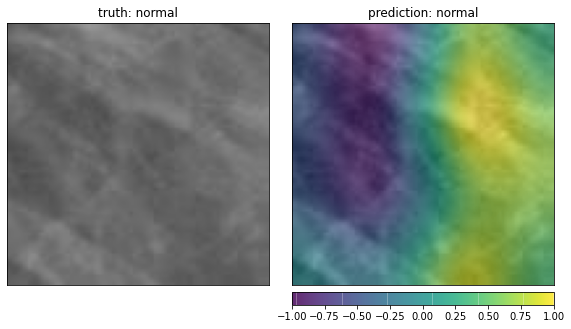

In [ ]:
plot_gradcam(index=7)

<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [ ]:
#print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
#print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(valid_predictions.cpu(), valid_targets.cpu()))
#print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(valid_targets, valid_targets))

Training score for the accuracy_score metric = 0.7819


You can add here other scores and result visualization.

In [ ]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(Y_train, Y_hat_train)
confusion_matrix(valid_predictions.cpu(), valid_targets.cpu())

array([[1152,  332],
       [ 142,  547]])

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
#scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
#scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))

#print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

Our workflow is different than the usual way of Codalab, the script may fail.  
You can ignore the error. The only important point is to produce the submission files.

In [28]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

/bin/bash: activate: No such file or directory
Using input_dir: /mnt/Data/MyData/Education/Master AI Saclay 2020/Content/AI/Project A/bundle-file/FILES
Using output_dir: /mnt/Data/MyData/Education/Master AI Saclay 2020/Content/AI/Project A/bundle-file/starting_kit/sample_result_submission
Using program_dir: /mnt/Data/MyData/Education/Master AI Saclay 2020/Content/AI/Project A/bundle-file/starting_kit/ingestion_program
Using submission_dir: /mnt/Data/MyData/Education/Master AI Saclay 2020/Content/AI/Project A/bundle-file/starting_kit/sample_code_submission
[+] Done
[+] Overall time spent  0.81 sec ::  Overall time budget  0.00 sec


<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [29]:
scoring_output_dir = 'scoring_output'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

/bin/bash: activate: No such file or directory


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [30]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
../sample_code_submission_21-02-28-15-23.zip
../sample_result_submission_21-02-28-15-23.zip
